In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
from torch.optim import Adam

import os.path as osp
from tqdm import tqdm, tqdm_notebook
from pytorch_transformers import *

from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.preprocessing import MinMaxScaler

import os
from pathlib import Path
import os.path as osp

from utils import normalize_price
from transformers import BertModel



C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
C:\softwares\conda4.8.2-python3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\softwares\conda4.

In [2]:
scaler = MinMaxScaler()

In [3]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 17px;
</style>

In [4]:
data_path = osp.join(os.getcwd(),'Data')

In [5]:
ens_train_df = pd.read_csv(data_path + '/model.csv')
news_headlines = ens_train_df['News'].tolist()
max_daily_length = 400
all_headlines = []

for headline in news_headlines:
    if len(headline) > max_daily_length: 
        headline = headline[:max_daily_length]
    all_headlines.append(headline)

In [6]:
norm_price = scaler.fit_transform(ens_train_df['cap'].to_numpy().reshape(-1,1))

In [7]:
MAX_LEN = 400
batch_size = 4
input_ids=[]


sentences = ["[CLS] " + sentence + " [SEP]" for sentence in all_headlines]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
for i in tqdm_notebook(range(len(tokenized_texts))):
       input_ids.append(tokenizer.convert_tokens_to_ids(tokenized_texts[i]))        
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
#Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:    
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
    
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, norm_price,random_state=56, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=56, test_size=0.1)


train_inputs = torch.from_numpy(np.array(train_inputs)).long()
validation_inputs =  torch.from_numpy(np.array(validation_inputs)).long()
train_labels = torch.from_numpy(np.array(train_labels)).float()
validation_labels = torch.from_numpy(np.array(validation_labels)).float()
train_masks = torch.from_numpy(np.array(train_masks)).float()
validation_masks = torch.from_numpy(np.array(validation_masks)).float()

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

C:\softwares\conda4.8.2-python3.7\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [8]:
import BertCapsule

In [9]:
#initialize model with the best hyper parameters
LR = 2e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('device ',device)
model = BertCapsule.bertCapsuleModel(input_dim_capsule=768,
                                     num_capsule=20,dim_capsule=32,
                                     routings=5,kernel_size=(9,1),
                                     dropout_p=0.25,T_epsilon = 1e-7,
                                     batch_size=4)

criterion = BertCapsule.RMSELoss()

if torch.cuda.is_available():
    model = model.to(device) 
    criterion.to(device) 
    
optimizer = AdamW(model.parameters(),lr=LR,correct_bias=False) 

device  cuda


In [10]:
# Store our loss and accuracy for plotting
train_loss_set = []
epochs = 10
# trange is a tqdm wrapper around the normal python range
for epoch in tqdm_notebook(range(epochs)): 
    # Train the data for one epoch
    for i, batch in enumerate(train_dataloader):
            
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)            
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch 
      # Forward pass
      output = model.forward(b_input_ids, b_input_mask)           
      # loss
      loss = criterion(output, b_labels) 
      #append all losses for plotting
      train_loss_set.append(loss) 

      optimizer.zero_grad()           # clear gradients for this training step
      loss.backward()                 # backpropagation, compute gradients
      optimizer.step()                # apply gradients
    
      if (i) % 50 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss))   


C:\softwares\conda4.8.2-python3.7\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


output shape  torch.Size([4, 1])


..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Epoch [1/10], Loss: 0.5190
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  to

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
Epoch [1/10], Loss: 0.0640
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  to

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
Epoch [1/10], Loss: 0.0659
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  to

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output sha

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output sha

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
Epoch [3/10], Loss: 0.0699
output shape  torch.Size([4, 1])
output shape  to

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output sha

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
Epoch [4/10], Loss: 0.0484
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  to

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
Epoch [4/10], Loss: 0.0548
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  to

Epoch [5/10], Loss: 0.0597
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  to

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
Epoch [5/10], Loss: 0.0291
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  to

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output sha

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output sha

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
Epoch [7/10], Loss: 0.0245
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  to

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
Epoch [7/10], Loss: 0.0682
output shape  torch.Size([4, 1])
output shape  to

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([3, 1])
output shape  torch.Size([4, 1])
Epoch [8/10], Loss: 0.0945
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  to

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
Epoch [8/10], Loss: 0.0259
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  to

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
Epoch [8/10], Loss: 0.0500
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  to

Epoch [9/10], Loss: 0.0274
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  to

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
Epoch [9/10], Loss: 0.0216
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  to

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output sha

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output sha

In [11]:
# Test the model
predictions = []
test_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(validation_dataloader):
        
        batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
      # Forward pass
        outputs = model.forward(b_input_ids,b_input_mask)
      # print (outputs)target.
        test_label = b_labels.cpu().data.numpy().tolist()
        test_labels.append(test_label)
        prediction = outputs.cpu().data.numpy().flatten().tolist()   
        predictions.append(prediction)

output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output shape  torch.Size([4, 1])
output sha

In [12]:
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [13]:
test_labels_arr = []
for x in test_labels:
    for y in x:
        test_labels_arr.append(y)

In [14]:
predictions_arr = []
for x in predictions:
    for y in x:
        predictions_arr.append(y)

In [15]:
mse(test_labels_arr, predictions_arr,squared=False)

0.0756390119134629

In [16]:
mae(test_labels_arr, predictions_arr)

0.04634930193424225

In [18]:
test_labels_arr = [test[0] for test in test_labels_arr]

In [23]:
datapoints = [i for i in range(0,len(test_labels_arr))]

In [24]:
main_df = pd.DataFrame.from_dict({'days':datapoints,'test values' :test_labels_arr,'predicted values' : predictions_arr})

<Figure size 1152x864 with 0 Axes>

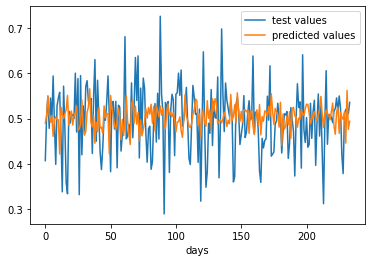

In [29]:
plt.figure().set_size_inches(16,12)
main_df.plot(label='test values',x='days',y='test values')
main_df['predicted values'].plot(label='predicted values')

plt.legend()

In [30]:
type(model.state_dict)

method

In [31]:
model_path = osp.join(os.getcwd(),'Models')
torch.save(model.state_dict(), model_path + '/bert-capsule.pth')

In [32]:
from pickle import dump

In [33]:
dump(scaler, open(model_path + '/bert-capsule-scaler.pkl', 'wb'))

In [34]:
del loss
del model
del train_inputs
del validation_inputs
del train_data
del validation_data
del train_sampler
del validation_sampler
del train_dataloader
del validation_dataloader
del train_labels
del validation_labels

del ens_train_df
del all_headlines
del news_headlines
del norm_price
del sentences
del tokenized_texts
del input_ids